This notebook assumes access to detrended, denoised signals and calculates various parameters (and uncertainties) from these signals and serves as an area for experimentation with methods for parameter estimation. The parameters estimated within this notebook are: 
 - peak to peak time
 - amplitude.....

In [21]:
%run "Data_PreProcessing.ipynb" #allowing access to the filtered database with preprocessed signals

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:03<00:00, 73.21it/s]


In [22]:
from scipy.signal import find_peaks, correlate

In [23]:
test_indice = 0 #set test signal to be used throughout notebook
signal = butterworth_detrended_signals[test_indice] #defining filter type to use in this notebook

In [61]:
def parameter_averages(parameter, health_state):
    """
    calculates healthy and unhealthy means and std of parameter for easy comparisson
    returns np.array containing: healthy mean, healthy std, unhealthy mean, unhealhty std
    """
    encoded_health_state = [True if label == 'Unhealthy' else False for label in health_state]
    
    unhealthy_param = parameter[encoded_health_state]
    healthy_param = parameter[~np.array(encoded_health_state)]
    
    unhealthy_param_av = np.mean(unhealthy_param)
    unhealthy_param_std = np.std(unhealthy_param)
    
    healthy_param_av = np.mean(healthy_param)
    healthy_param_std = np.std(healthy_param)
    
    return np.array([healthy_param_av, healthy_param_std, unhealthy_param_av, unhealthy_param_std])

### Peak to Peak times and Peak amplitude (R)

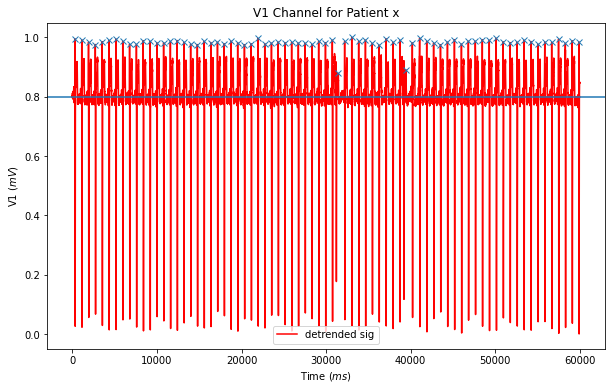

In [62]:
peaks, _ = find_peaks(signal, distance=500, height = 0.1) #can add height but still dont know how to do exactly

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(signal, color = 'red', label = 'detrended sig')
ax.plot(peaks, signal[peaks], 'x')
ax.axhline(np.median(signal))

ax.set_xlabel(r'Time ($ms$)')
ax.set_ylabel(r'V1 ($mV$)')
ax.set_title('V1 Channel for Patient x')

ax.legend()
plt.show()

identified peaks, should get rid of first and last values in it, wont hurt much even if is correct ones. I shall now implement a function to perform this for all signals in the database, may have to find a way to automatically calculate the distance between signals, find way to get rid of outliers....

In [63]:
#why do some signals have really large tails and some have larger peaks?

In [64]:
def peak_to_peak(signal, distance):
    peaks, _ = find_peaks(signal, distance = distance)
    peak_to_peaks = peaks[1:-1]

    # Calculate differences between adjacent peak indices
    peak_distances = np.diff(peak_to_peaks)

    # Compute the average distance between peaks
    peak_av = np.mean(peak_distances)
    #peak_std = np.std(peak_distances) dont think we want this??
    
    #calculating amplitude of R peak
    peak_amp = signal[peak_to_peaks] - np.median(signal)
    peak_amp_av = np.mean(peak_amp)
    peak_amp_std = np.std(peak_amp)
    
    return peak_amp_av, peak_av


peak_to_peak_averages = np.zeros(shape = no_patients)
peak_amp_average = np.zeros(shape = no_patients)
for i, signal in enumerate(butterworth_detrended_signals):
    peak_amp_av, peak_av = peak_to_peak(signal, 600)
    peak_to_peak_averages[i] = peak_av
    peak_amp_average[i] = peak_amp_av 
#print(peak_amp_average[test_indice])


In [65]:
health_state = allowed_patients.get_diagnoses()

ptp_averages = parameter_averages(peak_to_peak_averages, health_state)
amp_averages = parameter_averages(peak_amp_average, health_state)

print("Unhealthy R-R:", ptp_averages[2], ptp_averages[3])
print("Healthy R-R:", ptp_averages[0], ptp_averages[1])

print("Unhealthy R amplitude:", amp_averages[2], amp_averages[3])
print("Healthy R amplitude:", amp_averages[0], amp_averages[1])

Unhealthy R-R: 816.2688950433381 114.9463194502719
Healthy R-R: 878.0488651974767 111.76348662559417
Unhealthy R amplitude: 0.20948234732778886 0.1609335464799934
Healthy R amplitude: 0.20720100744305475 0.08621842953445324


The above suggest that in the case of the R-R time the means are different however the standard deviations are similar, however the opposite is the case for the amplitudes.

In [28]:
#can see is difference between the means but standard deviation is similar

## Fractal dimension

- use signals to reconstruct dynamical attractors, used to quantify differences in signals
- calculate time delay, point where autocorrelation drops to 1/e
- each time series is then embedded into M dimension
- perform SVD on embedded signal to get embedded attractor
- perform fractal analysis on embedded attractor

In [29]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alottttt faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau



In [30]:
#this takes foreverrrrrr - fixed using scipy.correlate
tau = np.zeros(shape = no_patients, dtype=int)
for i in tqdm(range(0, no_patients)):
    tau[i] = find_time_delay(butterworth_detrended_signals[i])

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:02<00:00, 91.15it/s]


In [31]:
#print(tau)

In [32]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 5 

#creates list of embedded arrays i.e. no_patients * len(embedded) * M
embedded_signals = []
for i in tqdm(range(0, no_patients)):
    embedded_signals.append(embed_time_series(butterworth_detrended_signals[i], tau[i], M))

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:19<00:00, 11.80it/s]


(59860, 5)


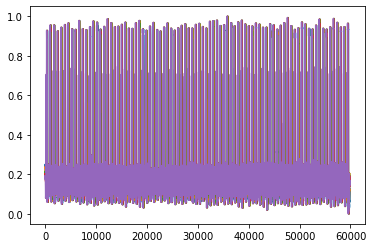

In [33]:
fig, axes = plt.subplots()

print(embedded_signals[3].shape)
axes.plot(embedded_signals[0])
plt.show()

In [34]:
# performing SVD

from sklearn.preprocessing import StandardScaler
from numpy.linalg import svd

# Standardize the embedded signal
scaler = StandardScaler()
embedded_signal_std = scaler.fit_transform(embedded_signals[0])

# Perform SVD
U, S, VT = svd(embedded_signal_std, full_matrices=False)

# Get the principal components
PCs = U @ np.diag(S)

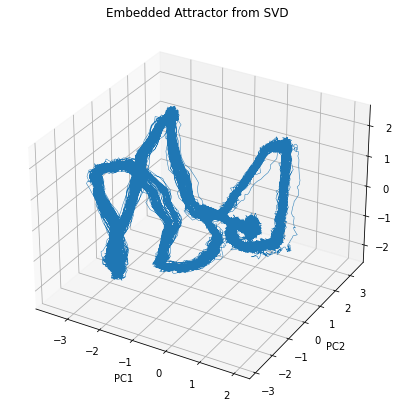

In [35]:
#visualising attractors in 3D
 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(PCs[:, 0], PCs[:, 1], PCs[:, 2], lw=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Embedded Attractor from SVD')

plt.show()

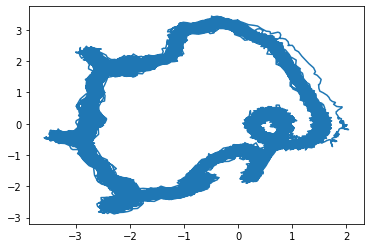

In [36]:
#in 2D

fig, axes = plt.subplots()

axes.plot(PCs[:, 0], PCs[:, 1])

In [37]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope

# Define box sizes
box_sizes = np.logspace(-1, 1, num=10)  # Adjust as needed

# Calculate the fractal dimension
fd = fractal_dimension(PCs[:, :3], box_sizes)  # Using the first three principal components

In [38]:
print(f"Fractal Dimension: {fd}")

Fractal Dimension: 1.498215879573484


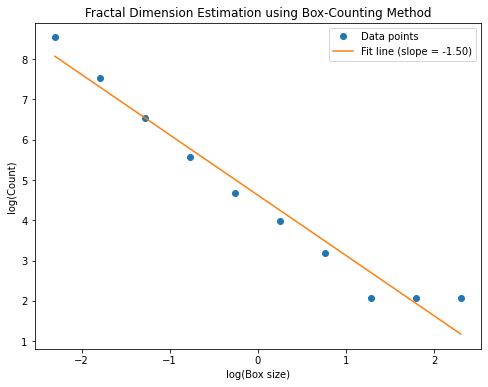

In [39]:
# plotting the log-log plot for the box-counting method
import matplotlib.pyplot as plt

log_box_sizes = np.log(box_sizes)
log_counts = np.log(box_counting(PCs[:, :3], box_sizes))

plt.figure(figsize=(8, 6))
plt.plot(log_box_sizes, log_counts, 'o', label='Data points')
plt.plot(log_box_sizes, np.polyval(np.polyfit(log_box_sizes, log_counts, 1), log_box_sizes),
         label=f'Fit line (slope = {-fd:.2f})')
plt.xlabel('log(Box size)')
plt.ylabel('log(Count)')
plt.legend()
plt.title('Fractal Dimension Estimation using Box-Counting Method')
plt.show()

Code to calculate fractal dimension only for each patient:

In [69]:
#research this properly before doing this final implementation but this allows calculation of just fractal dimension from all signals
def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :3], box_sizes)  # uses the first three principal components
    return fd

fd = np.zeros(shape = no_patients)

for i in tqdm(range(0, no_patients)):
    fd[i] = calc_fractal_dim(embedded_signals[i])
    


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [02:01<00:00,  1.89it/s]


In [70]:
fd_averages = parameter_averages(fd, health_state)
print(fd_averages)

[1.46177984 0.08849689 1.49050233 0.15111816]
